In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import netCDF4 as nc
import cmocean as cm
#from xgcm import Grid

### Make a 2D ncfile of bathymetry
Use ISOMIP+ Ocean1 file to get dimension names more easily

In [6]:
!pwd

/Users/claireyung/mom6/MOM6-examples/ocean_only/ISOMIP/2D-triangle


In [7]:
ISOMIPthick = xr.open_dataset('../layer-melton/INPUT/Ocean1_3D.nc')
ISOMIPthick

<xarray.Dataset>
Dimensions:  (ny: 40, nx: 240)
Dimensions without coordinates: ny, nx
Data variables:
    thick    (ny, nx) float64 ...
    area     (ny, nx) float64 ...

In [22]:
ISOMIPthick.area.values

array([[4000000., 4000000., 4000000., ...,       0.,       0.,       0.],
       [4000000., 4000000., 4000000., ...,       0.,       0.,       0.],
       [4000000., 4000000., 4000000., ...,       0.,       0.,       0.],
       ...,
       [4000000., 4000000., 4000000., ...,       0.,       0.,       0.],
       [4000000., 4000000., 4000000., ...,       0.,       0.,       0.],
       [4000000., 4000000., 4000000., ...,       0.,       0.,       0.]])

In [23]:
TwoDtrianglethick = ISOMIPthick.copy()
TwoDtrianglethick = TwoDtrianglethick.isel(ny = [0,1])
TwoDtrianglethick['thick'] = -(720/2/120)*(TwoDtrianglethick.thick*0+TwoDtrianglethick.nx)+720/2
TwoDtrianglethick['thick'] = TwoDtrianglethick.thick.where(TwoDtrianglethick.thick>0).fillna(0)
TwoDtrianglethick['area'] = (TwoDtrianglethick.area*0+2000**2).where(TwoDtrianglethick.thick>0).fillna(0)


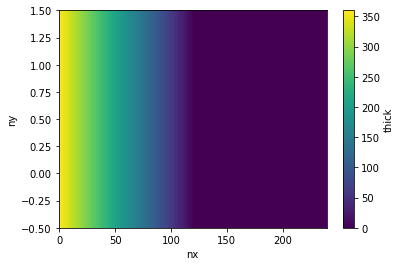

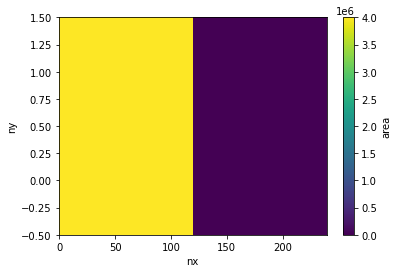

In [24]:
TwoDtrianglethick.thick.plot()
plt.show()
TwoDtrianglethick.area.plot()
plt.show()


In [26]:
!mkdir INPUT

In [27]:
#save as netcdf
TwoDtrianglethick.to_netcdf('INPUT/TwoDtrianglethick.nc')


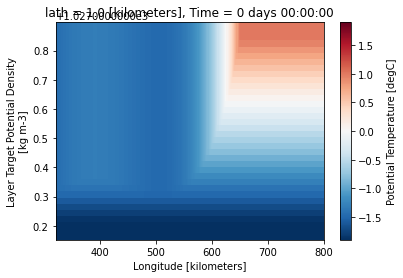

In [30]:
#make sponge - needs to be done by running model I think.
ISOMIPsponge = xr.open_dataset('../layer-melton/INPUT/3D_LAYER_WARM_IC.nc')
ISOMIPsponge.Temp.isel(lath = 0).plot()

# make sponge
run with and without `FIT_SALINITY`

https://github.com/claireyung/mom6-isomip-svtest/blob/Testing/layer-cold-noshelf/setupfiles/make-sponge.ipynb

https://github.com/gustavo-marques/ISOMIP/blob/master/setup/python/make_sponge.py



In [30]:
!cp setupfiles/ISOMIP_IC-FITSALINITYTRUE-NK144-COLD.nc INPUT/LAYER_COLD_NK144.nc


In [31]:
wd = 'setupfiles/'
fname1 = wd+'ISOMIP_IC-FITSALINITYFALSE-NK144-COLD.nc'

fname2 = 'INPUT/LAYER_COLD_NK144.nc'
salt = nc.Dataset(fname1).variables['Salt'][:]
file = nc.Dataset(fname2,'r+')
file.variables['Salt'][:]=salt[:]
file.close()
print('*** Variable Salt was written successfully. \n')


*** Variable Salt was written successfully. 



# plot results

In [2]:
ave = False ## True means use 5 daily average rather than hourly prog
basee = '/Users/claireyung/mom6/MOM6-examples/ocean_only/ISOMIP/2D-triangle/archive'
def open_files(label):
    base = basee 
    prog = xr.open_dataset(base + '/prog-'+label+'.nc')
    return prog
def open_IC(folder):
    base = basee 
    IC = xr.open_dataset(base + '/ISOMIP_IC-'+label+'.nc')
    return IC
def open_mom(folder):
    base = basee 
    IC = xr.open_dataset(base + '/mom-'+label+'.nc')
    return IC
def open_ice(folder):
    base = basee 
    IC = xr.open_dataset(base + '/ice-'+label+'.nc')
    return IC

def plot(ax,yy0,tt,i,variable,varname,vmin1,vmax1,cmap,ymax):
    prog = open_files(label)
    ocean_static = xr.open_dataset('ocean_geometry.nc')
#     grid = Grid(prog,coords={"x":{"center":"xh","outer":"xq"},
#                              "y":{"center":"yh","outer":"yq"},
#                              "z":{"center":"zl","outer":"zi"}},periodic=False)
    file_name = label
    IC = open_IC(label)
    depth = prog.e
    lon = ocean_static.geolon
    dataplot = variable

    xx = lon
    if (varname == "uo") or (varname == "PFu"): dataplot = dataplot[:,:,:,:-1]
    levels = np.linspace(vmin1, vmax1, 51)
    yy = depth[:,:,yy0,:]
    z_levels = yy.shape[1]
    yi = np.linspace(0,5000,z_levels) 
    xi, yyi = np.meshgrid(xx[yy0,:], yi) 
    cax = ax.pcolormesh(xi,yy[tt,...],dataplot[tt,:,yy0,:],vmin = vmin1, vmax = vmax1, cmap = cmap)
    
    plt.colorbar(cax, ax = ax, label = varname)
    
    ## plot interface heights
    i_heights = prog.e # this is 'Interface Height Relative to Mean Sea Level'
    # do for one time
    i_heights = i_heights.isel(Time = tt)
    # take zonal mean
    i_heights = i_heights.isel(yh = yy0)#.mean('xh')

    # plot a line of layer depths, layer by layer
    nz = len(i_heights.zi)
    xh = prog.xh

    for i in range(nz):
        ax.plot(xh,i_heights[i], color = 'k', linewidth = 0.5)
    
    ax.set_ylim(ymin=-ymax,ymax=0)
    ax.set_ylabel('Depth (m)')
    ax.set_xlabel('x (km)')
    ax.set_title(varname+' , ' +label)
    


/var/folders/dq/psqyj9ns2m9b5kxdvtqz90bm0000gp/T/ipykernel_50366/824155817.py:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  cax = ax.pcolormesh(xi,yy[tt,...],dataplot[tt,:,yy0,:],vmin = vmin1, vmax = vmax1, cmap = cmap)
/var/folders/dq/psqyj9ns2m9b5kxdvtqz90bm0000gp/T/ipykernel_50366/824155817.py:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  cax = ax.pcolormesh(xi,yy[tt,...],dataplot[tt,:,yy0,:],vmin = vmin1, vmax = vmax1, cmap = cmap)
/var/folders/d

Text(0.5, 0.98, 'Time = 1200 hours')

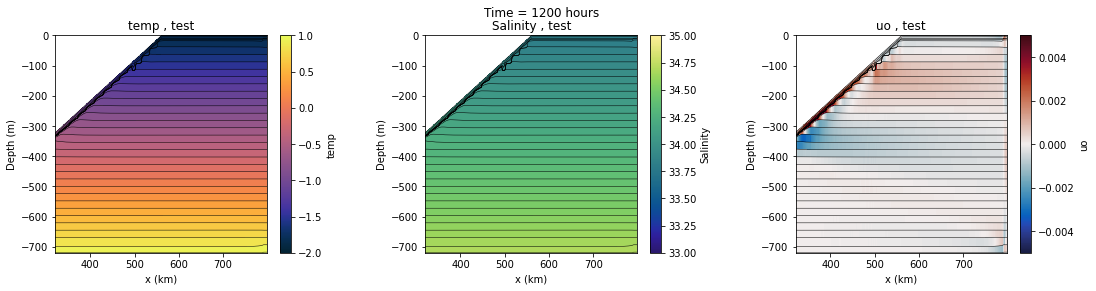

In [3]:
label = 'test'

fig, axes = plt.subplots(ncols = 3, figsize = (18,4))
prog = open_files(label)
IC = open_IC(label)
x = 0
time = 24*50-1
ymax = 720
plot(axes[0],x,time,0,prog.temp,"temp",-2,1,cm.cm.thermal,ymax)

prog = open_files(label)
IC = open_IC(label)

plot(axes[1],x,time,0,prog.salt,"Salinity",33,35,cm.cm.haline,ymax)
#plot(axes[1],x,time,0,prog.salt,"salt",33.7,34.6,cm.cm.haline,ymax)

prog = open_files(label)
IC = open_IC(label)

plot(axes[2],x,time,0,prog.u,"uo",-5e-3,5e-3,cm.cm.balance,ymax)

fig.subplots_adjust(wspace = 0.4)
fig.suptitle('Time = '+str(time+1)+' hours')

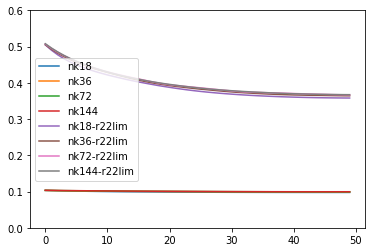

In [15]:
label = 'nk18'
ice = open_ice(label)
timearr = np.arange(len(ice.Time))
plt.plot(timearr, ice.melt_rate.mean(['xT','yT']).values, label = label)

label = 'nk36'
ice = open_ice(label)
timearr = np.arange(len(ice.Time))
plt.plot(timearr, ice.melt_rate.mean(['xT','yT']).values, label = label)

label = 'nk72'
ice = open_ice(label)
timearr = np.arange(len(ice.Time))
plt.plot(timearr, ice.melt_rate.mean(['xT','yT']).values, label = label)

label = 'nk144'
ice = open_ice(label)
timearr = np.arange(len(ice.Time))
plt.plot(timearr, ice.melt_rate.mean(['xT','yT']).values, label = label)

label = 'nk18-r22lim'
ice = open_ice(label)
timearr = np.arange(len(ice.Time))
plt.plot(timearr, ice.melt_rate.mean(['xT','yT']).values, label = label)
label = 'nk36-r22lim'
ice = open_ice(label)
timearr = np.arange(len(ice.Time))
plt.plot(timearr, ice.melt_rate.mean(['xT','yT']).values, label = label)
label = 'nk72-r22lim'
ice = open_ice(label)
timearr = np.arange(len(ice.Time))
plt.plot(timearr, ice.melt_rate.mean(['xT','yT']).values, label = label)
label = 'nk144-r22lim'
ice = open_ice(label)
timearr = np.arange(len(ice.Time))
plt.plot(timearr, ice.melt_rate.mean(['xT','yT']).values, label = label)
plt.ylim(0,0.6)
plt.legend()

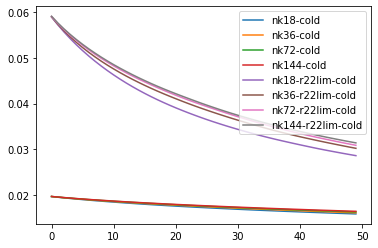

In [35]:
label = 'nk18-cold'
ice = open_ice(label)
timearr = np.arange(len(ice.Time))
plt.plot(timearr, ice.melt_rate.mean(['xT','yT']).values, label = label)

label = 'nk36-cold'
ice = open_ice(label)
timearr = np.arange(len(ice.Time))
plt.plot(timearr, ice.melt_rate.mean(['xT','yT']).values, label = label)

label = 'nk72-cold'
ice = open_ice(label)
timearr = np.arange(len(ice.Time))
plt.plot(timearr, ice.melt_rate.mean(['xT','yT']).values, label = label)

label = 'nk144-cold'
ice = open_ice(label)
timearr = np.arange(len(ice.Time))
plt.plot(timearr, ice.melt_rate.mean(['xT','yT']).values, label = label)

label = 'nk18-r22lim-cold'
ice = open_ice(label)
timearr = np.arange(len(ice.Time))
plt.plot(timearr, ice.melt_rate.mean(['xT','yT']).values, label = label)
label = 'nk36-r22lim-cold'
ice = open_ice(label)
timearr = np.arange(len(ice.Time))
plt.plot(timearr, ice.melt_rate.mean(['xT','yT']).values, label = label)
label = 'nk72-r22lim-cold'
ice = open_ice(label)
timearr = np.arange(len(ice.Time))
plt.plot(timearr, ice.melt_rate.mean(['xT','yT']).values, label = label)
label = 'nk144-r22lim-cold'
ice = open_ice(label)
timearr = np.arange(len(ice.Time))
plt.plot(timearr, ice.melt_rate.mean(['xT','yT']).values, label = label)
#plt.ylim(0,0.6)
plt.legend()

/var/folders/dq/psqyj9ns2m9b5kxdvtqz90bm0000gp/T/ipykernel_50366/824155817.py:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  cax = ax.pcolormesh(xi,yy[tt,...],dataplot[tt,:,yy0,:],vmin = vmin1, vmax = vmax1, cmap = cmap)
/var/folders/dq/psqyj9ns2m9b5kxdvtqz90bm0000gp/T/ipykernel_50366/824155817.py:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  cax = ax.pcolormesh(xi,yy[tt,...],dataplot[tt,:,yy0,:],vmin = vmin1, vmax = vmax1, cmap = cmap)
/var/folders/d

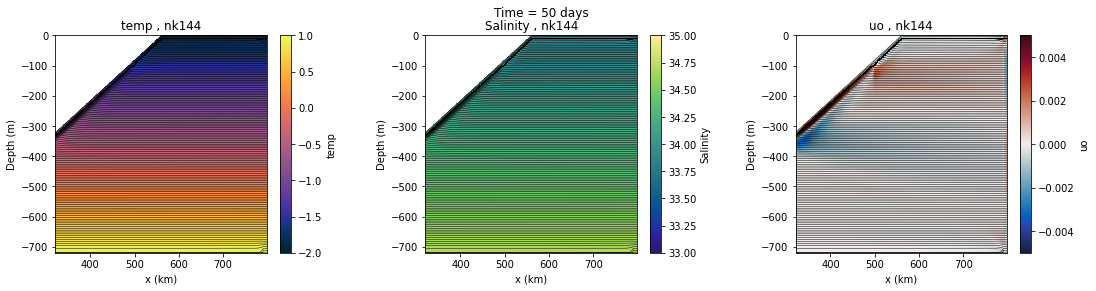

In [11]:
label = 'nk144'

fig, axes = plt.subplots(ncols = 3, figsize = (18,4))
prog = open_files(label)
IC = open_IC(label)
x = 0
time = 49
ymax = 720
plot(axes[0],x,time,0,prog.temp,"temp",-2,1,cm.cm.thermal,ymax)

prog = open_files(label)
IC = open_IC(label)

plot(axes[1],x,time,0,prog.salt,"Salinity",33,35,cm.cm.haline,ymax)
#plot(axes[1],x,time,0,prog.salt,"salt",33.7,34.6,cm.cm.haline,ymax)

prog = open_files(label)
IC = open_IC(label)

plot(axes[2],x,time,0,prog.u,"uo",-5e-3,5e-3,cm.cm.balance,ymax)

fig.subplots_adjust(wspace = 0.4)
fig.suptitle('Time = '+str(time+1)+' days')
plt.show()


/var/folders/dq/psqyj9ns2m9b5kxdvtqz90bm0000gp/T/ipykernel_50366/824155817.py:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  cax = ax.pcolormesh(xi,yy[tt,...],dataplot[tt,:,yy0,:],vmin = vmin1, vmax = vmax1, cmap = cmap)
/var/folders/dq/psqyj9ns2m9b5kxdvtqz90bm0000gp/T/ipykernel_50366/824155817.py:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  cax = ax.pcolormesh(xi,yy[tt,...],dataplot[tt,:,yy0,:],vmin = vmin1, vmax = vmax1, cmap = cmap)
/var/folders/d

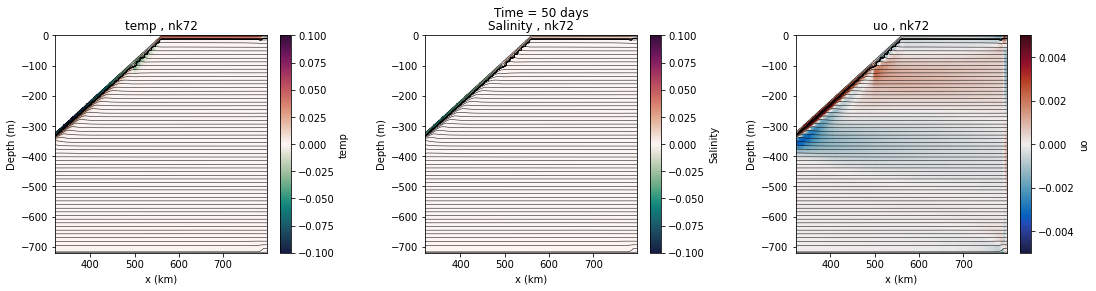

In [38]:
label = 'nk72'

fig, axes = plt.subplots(ncols = 3, figsize = (18,4))
prog = open_files(label)
IC = open_IC(label)
x = 0
time = 49
ymax = 720
plot(axes[0],x,time,0,prog.temp-prog.temp.isel(Time = 0),"temp",-0.1,0.1,cm.cm.curl,ymax)

prog = open_files(label)
IC = open_IC(label)

plot(axes[1],x,time,0,prog.salt-prog.salt.isel(Time = 0),"Salinity",-0.1,0.1,cm.cm.curl,ymax)
#plot(axes[1],x,time,0,prog.salt,"salt",33.7,34.6,cm.cm.haline,ymax)

prog = open_files(label)
IC = open_IC(label)

plot(axes[2],x,time,0,prog.u,"uo",-5e-3,5e-3,cm.cm.balance,ymax)

fig.subplots_adjust(wspace = 0.4)
fig.suptitle('Time = '+str(time+1)+' days')
plt.show()


/var/folders/dq/psqyj9ns2m9b5kxdvtqz90bm0000gp/T/ipykernel_50366/824155817.py:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  cax = ax.pcolormesh(xi,yy[tt,...],dataplot[tt,:,yy0,:],vmin = vmin1, vmax = vmax1, cmap = cmap)
/var/folders/dq/psqyj9ns2m9b5kxdvtqz90bm0000gp/T/ipykernel_50366/824155817.py:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  cax = ax.pcolormesh(xi,yy[tt,...],dataplot[tt,:,yy0,:],vmin = vmin1, vmax = vmax1, cmap = cmap)


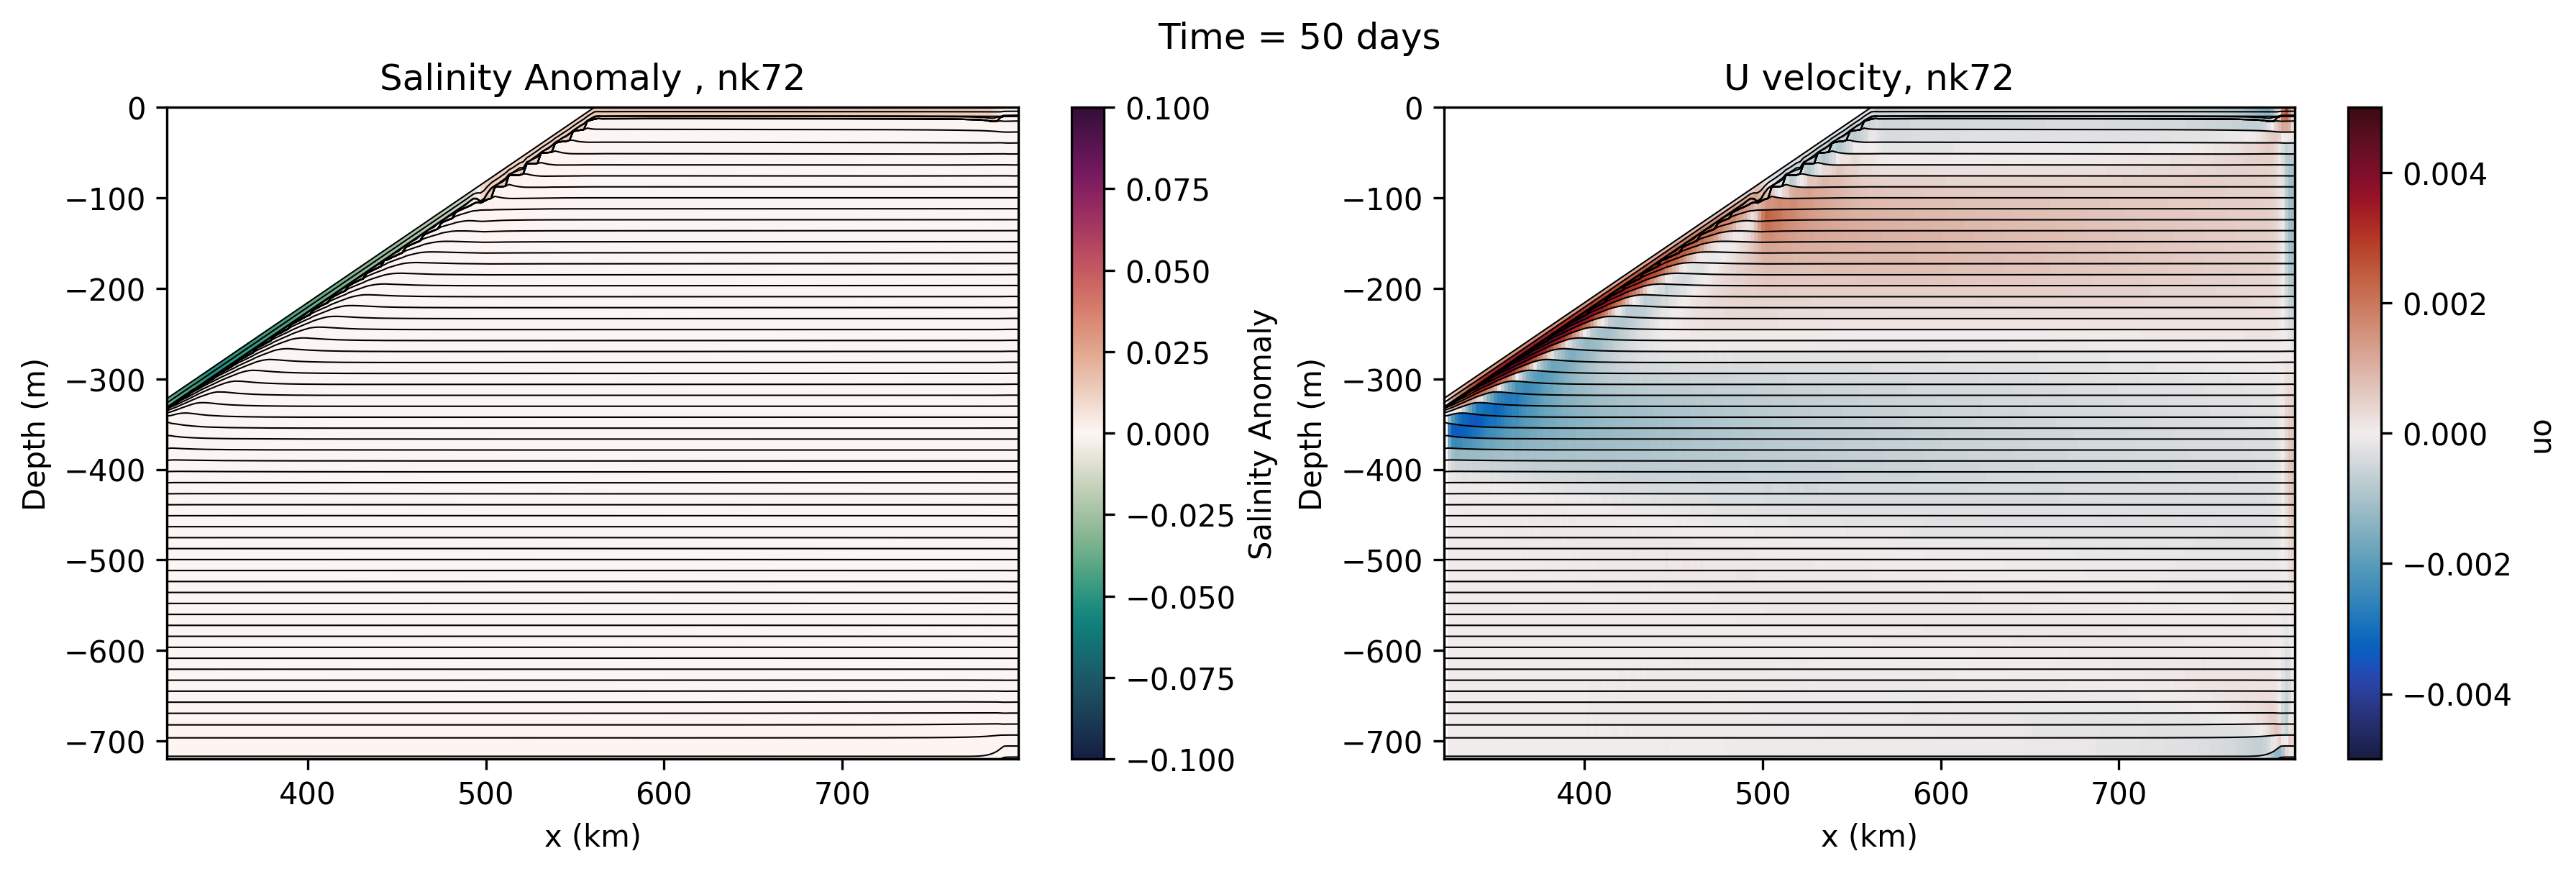

In [43]:
label = 'nk72'

fig, axes = plt.subplots(ncols = 2, figsize = (14,4),dpi = 300)
prog = open_files(label)
IC = open_IC(label)
x = 0
time = 49
ymax = 720
#plot(axes[0],x,time,0,prog.temp-prog.temp.isel(Time = 0),"temp",-0.1,0.1,cm.cm.curl,ymax)

prog = open_files(label)
IC = open_IC(label)

plot(axes[0],x,time,0,prog.salt-prog.salt.isel(Time = 0),"Salinity Anomaly",-0.1,0.1,cm.cm.curl,ymax)
#plot(axes[1],x,time,0,prog.salt,"salt",33.7,34.6,cm.cm.haline,ymax)

prog = open_files(label)
IC = open_IC(label)

plot(axes[1],x,time,0,prog.u,"uo",-5e-3,5e-3,cm.cm.balance,ymax)
axes[1].set_title('U velocity, nk72')
fig.subplots_adjust(wspace = 0.2)
fig.suptitle('Time = '+str(time+1)+' days')
plt.show()

fig.savefig('fig.png',dpi = 300)

/var/folders/dq/psqyj9ns2m9b5kxdvtqz90bm0000gp/T/ipykernel_50366/824155817.py:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  cax = ax.pcolormesh(xi,yy[tt,...],dataplot[tt,:,yy0,:],vmin = vmin1, vmax = vmax1, cmap = cmap)
/var/folders/dq/psqyj9ns2m9b5kxdvtqz90bm0000gp/T/ipykernel_50366/824155817.py:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  cax = ax.pcolormesh(xi,yy[tt,...],dataplot[tt,:,yy0,:],vmin = vmin1, vmax = vmax1, cmap = cmap)
/var/folders/d

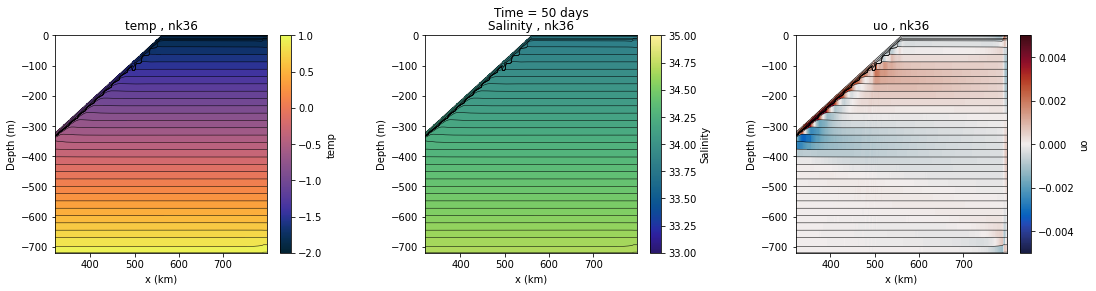

In [7]:
label = 'nk36'

fig, axes = plt.subplots(ncols = 3, figsize = (18,4))
prog = open_files(label)
IC = open_IC(label)
x = 0
time = 49
ymax = 720
plot(axes[0],x,time,0,prog.temp,"temp",-2,1,cm.cm.thermal,ymax)

prog = open_files(label)
IC = open_IC(label)

plot(axes[1],x,time,0,prog.salt,"Salinity",33,35,cm.cm.haline,ymax)
#plot(axes[1],x,time,0,prog.salt,"salt",33.7,34.6,cm.cm.haline,ymax)

prog = open_files(label)
IC = open_IC(label)

plot(axes[2],x,time,0,prog.u,"uo",-5e-3,5e-3,cm.cm.balance,ymax)

fig.subplots_adjust(wspace = 0.4)
fig.suptitle('Time = '+str(time+1)+' days')
plt.show()


/var/folders/dq/psqyj9ns2m9b5kxdvtqz90bm0000gp/T/ipykernel_50366/824155817.py:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  cax = ax.pcolormesh(xi,yy[tt,...],dataplot[tt,:,yy0,:],vmin = vmin1, vmax = vmax1, cmap = cmap)
/var/folders/dq/psqyj9ns2m9b5kxdvtqz90bm0000gp/T/ipykernel_50366/824155817.py:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  cax = ax.pcolormesh(xi,yy[tt,...],dataplot[tt,:,yy0,:],vmin = vmin1, vmax = vmax1, cmap = cmap)
/var/folders/d

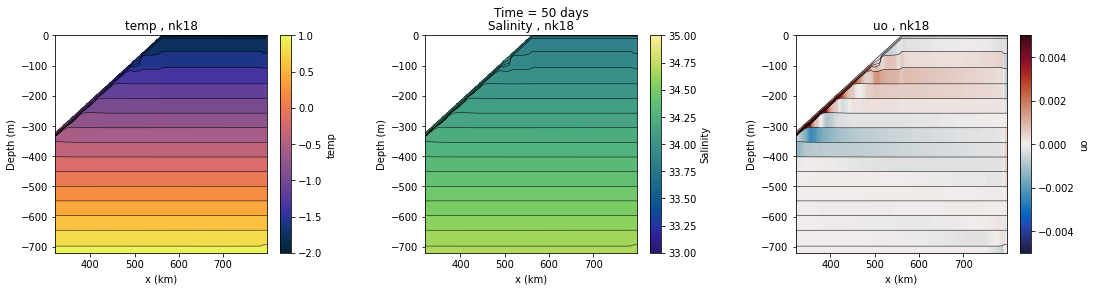

In [6]:
label = 'nk18'

fig, axes = plt.subplots(ncols = 3, figsize = (18,4))
prog = open_files(label)
IC = open_IC(label)
x = 0
time = 49
ymax = 720
plot(axes[0],x,time,0,prog.temp,"temp",-2,1,cm.cm.thermal,ymax)

prog = open_files(label)
IC = open_IC(label)

plot(axes[1],x,time,0,prog.salt,"Salinity",33,35,cm.cm.haline,ymax)
#plot(axes[1],x,time,0,prog.salt,"salt",33.7,34.6,cm.cm.haline,ymax)

prog = open_files(label)
IC = open_IC(label)

plot(axes[2],x,time,0,prog.u,"uo",-5e-3,5e-3,cm.cm.balance,ymax)

fig.subplots_adjust(wspace = 0.4)
fig.suptitle('Time = '+str(time+1)+' days')
plt.show()


/var/folders/dq/psqyj9ns2m9b5kxdvtqz90bm0000gp/T/ipykernel_50366/824155817.py:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  cax = ax.pcolormesh(xi,yy[tt,...],dataplot[tt,:,yy0,:],vmin = vmin1, vmax = vmax1, cmap = cmap)
/var/folders/dq/psqyj9ns2m9b5kxdvtqz90bm0000gp/T/ipykernel_50366/824155817.py:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  cax = ax.pcolormesh(xi,yy[tt,...],dataplot[tt,:,yy0,:],vmin = vmin1, vmax = vmax1, cmap = cmap)
/var/folders/d

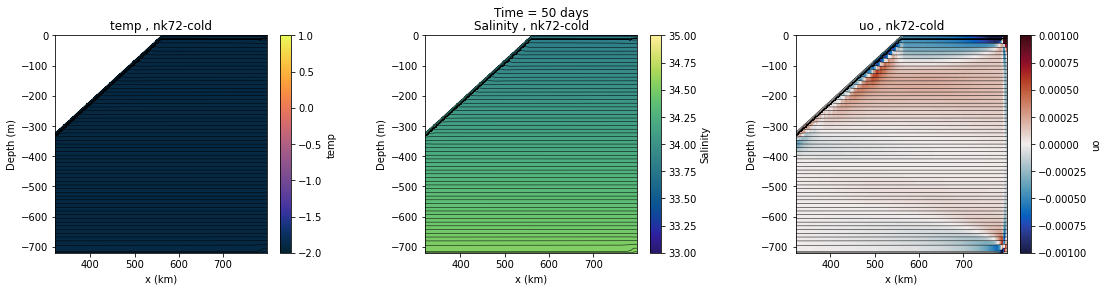

In [34]:
label = 'nk72-cold'

fig, axes = plt.subplots(ncols = 3, figsize = (18,4))
prog = open_files(label)
IC = open_IC(label)
x = 0
time = 49
ymax = 720
plot(axes[0],x,time,0,prog.temp,"temp",-2,1,cm.cm.thermal,ymax)

prog = open_files(label)
IC = open_IC(label)

plot(axes[1],x,time,0,prog.salt,"Salinity",33,35,cm.cm.haline,ymax)
#plot(axes[1],x,time,0,prog.salt,"salt",33.7,34.6,cm.cm.haline,ymax)

prog = open_files(label)
IC = open_IC(label)

plot(axes[2],x,time,0,prog.u,"uo",-1e-3,1e-3,cm.cm.balance,ymax)

fig.subplots_adjust(wspace = 0.4)
fig.suptitle('Time = '+str(time+1)+' days')
plt.show()
